# Predicting Bitcoin Prices using twitter sentiment  and time series data

In this project we are going to predict the prices of Bitcoin using deep learning. We will use two type of data. One will be simple numerci data as we did in our last project. Other will be sentiments from twitter tweets. As we know that not only numeric data can drive prices but the human speculation also can drive the prices. So we will combine them both and will see how the overall model perfomrms.

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import datetime

In [2]:
data=pd.read_csv('sentiment_full.csv')
#df['Date']=pd.to_datetime(['Date'],format="[datetime.date(%Y,%m,%d)]")
#print(df['Date'][1])
i = data['Date'].astype(str)\
      .str.findall('\d+')\
      .str.join('/')
data['Date'] = pd.to_datetime(i, errors='coerce')
data['Date'][1]

Timestamp('2018-02-27 00:00:00')

We will fetch bitcoin data from coinmarkte cap website as we did in our last work. The official site is here https://coinmarketcap.com/currencies/bitcoin/ .

In [3]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info=bitcoin_market_info[['Date','Close','Open','High','Low','Volume','Market Cap']]
#bitcoin_market_info.rename(columns={"Date":"Time"},inplace=True)
bitcoin_market_info.head()

,Date,Close,Open,High,Low,Volume,Market Cap
0,2018-03-14,8269.81,9214.65,9355.85,8068.59,6438230000,155891000000
1,2018-03-13,9194.85,9173.04,9470.38,8958.19,5991140000,155168000000
2,2018-03-12,9205.12,9602.93,9937.50,8956.43,6457400000,162421000000
3,2018-03-11,9578.63,8852.78,9711.89,8607.12,6296370000,149716000000
4,2018-03-10,8866.00,9350.59,9531.32,8828.47,5386320000,158119000000


We also have twitter data fetched using twitter API. We have analyzed the sentiments using textblob library. All the files are on Github repository so you can clone them and use them as per your need. 

We are loading the previously separately trained models on numeric data and sentiment data. We will see how they alone performs on making predictions and then we will combine them for better performance. 

In [4]:
from keras.models import load_model
model1 = load_model('close_price_lstm.h5')
model2=load_model('sentiment_price.h5')

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We will use numeric data for making predictions. As the model has been trained on all the data available in the market. It gives us good results.  

In [5]:
predict_data=np.array([[10725.60,10393.90,10878.50,10246.10,6966180000,175536000000],
                      [10366.70,9669.43,10475.00,9501.73,7287690000,163283000000],
                      [9664.73,9796.42,9923.22,9407.06,5706940000,165407000000],
                      [9813.07,10287.70,10597.20,9546.97,6917930000,173682000000],
                      [10301.10,9937.07,10487.30,9734.56,7739500000,167746000000],
                      [10005.00,10660.40,11039.10,9939.09,8040080000,179936000000]])
scaler = MinMaxScaler(feature_range=(0, 1))
a=scaler.fit_transform(predict_data)
pre=model1.predict(a.reshape(predict_data.shape[0],1,6))
phat=np.concatenate((pre,a[:,1:]),axis=1)
#print(phat)
predicted=scaler.inverse_transform(phat)
#print(predicted)

In [6]:
real_close=[10397.90,10725.60,10366.70,9664.73,9813.07,10301.10]
predicted_close=[]
date=[]
difference=[]
pr_change=[]
date=pd.date_range('02-23-2018','02-28-2018',freq='D').sort_values(ascending=False)
#print(date)
for i in range(predict_data.shape[0]):
    predicted_close.append(predicted[i,0])
    difference.append(abs(predicted[i,0]-real_close[i]))
    pr_change.append((abs(predicted[i,0]-real_close[i])/predicted[i,0])*100)
df=pd.DataFrame({'Date':date})
df['real_close']=real_close
df['predicted_close']=predicted_close
df['Difference']=difference
df['Percentage_change']=pr_change
print(df)

        Date  real_close  predicted_close  Difference  Percentage_change
0 2018-02-28    10397.90     10491.695183   93.795183           0.893995
1 2018-02-27    10725.60      9997.942656  727.657344           7.278071
2 2018-02-26    10366.70      9703.386253  663.313747           6.835900
3 2018-02-25     9664.73     10050.264651  385.534651           3.836065
4 2018-02-24     9813.07     10110.501936  297.431936           2.941812
5 2018-02-23    10301.10     10349.661903   48.561903           0.469212


In the above simple predictions we can see that our model is perfomring really well on making predictions for future prices. The simple reason is that the data is highly corelated with each other. Model get lot of information from it to learn the hidden pattern from the data.

Now we will load the dataframe which has both sentiment scores and numeric data of the close prices of Bitcoin. We will use first 8 rows of the data to make prediction later on.

In [7]:
dataframe=pd.read_csv('merged_price_sentiment.csv')
dataframe.drop("Unnamed: 0",axis=1,inplace=True)
dataframe[:8]

,Date,Close,Open,High,Low,Volume,Market Cap,Sentiment
0,2018-02-28,10397.90,10687.20,11089.80,10393.10,6936190000,180510000000,0.070307
1,2018-02-27,10725.60,10393.90,10878.50,10246.10,6966180000,175536000000,0.059455
2,2018-02-26,10366.70,9669.43,10475.00,9501.73,7287690000,163283000000,0.059455
3,2018-02-25,9664.73,9796.42,9923.22,9407.06,5706940000,165407000000,0.059455
4,2018-02-24,9813.07,10287.70,10597.20,9546.97,6917930000,173682000000,0.059455
5,2018-02-23,10301.10,9937.07,10487.30,9734.56,7739500000,167746000000,0.059455
6,2018-02-22,10005.00,10660.40,11039.10,9939.09,8040080000,179936000000,0.059455
7,2018-02-21,10690.40,11372.20,11418.50,10479.10,9405340000,191927000000,0.110849


In [8]:
dataframe.drop(['Date'],inplace=True,axis=1)
#print(dataframe.head())
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataframe)

In [9]:
columns=dataframe.columns
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(-i))
		names += [(j) for j in columns]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(i))
		if i == 0:
			names += [("output "+j) for j in columns]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

We have created a function which can convert the simple data into time-series data, where the outpu ot future result is of tommorw's data and the input will be today's data. The fucntion is pretty much simple to use. But before using it we are normalizing the data. As we know that normalizing data is neccessary before feeding the data to AI model. We have used Scikit-Learn to do this preprocessing of data. 

In [10]:
reframed = series_to_supervised(scaled, 1, 1)
#print(dataframe.shape)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

      Close      Open      High       Low    Volume  Market Cap  Sentiment  \
0  0.541059  0.524411  0.532558  0.530614  0.291347    0.529903   0.178618   
1  0.522282  0.486473  0.512080  0.490582  0.304849    0.491656   0.178618   
2  0.485554  0.493123  0.484077  0.485491  0.238465    0.498286   0.178618   
3  0.493316  0.518850  0.518282  0.493015  0.289321    0.524116   0.178618   
4  0.518849  0.500488  0.512704  0.503104  0.323822    0.505587   0.178618   

   output Close  
0      0.523914  
1      0.541059  
2      0.522282  
3      0.485554  
4      0.493316  


Now we have to reshape the data. As LSTM model,which we are going to build in next step only accepts input with 3-D shape. We are using numpy to do that. Below you can see the code of it and shape of the data also.

In [11]:
values=reframed.values
train = values[9:550, :]
test = values[550:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(541, 1, 7) (541,) (197, 1, 7) (197,)


Now as we have data and it is reshaped as well as well normalized we can feed it to LSTM model for training and future predictions. To create model we are using Keras framework as it is most easy to use and very much user friednly. Below is the code to create simple LSTM model in keras. Our model has 80 neurons and finally only one output unit as we just want to predict the prices. 

Train on 541 samples, validate on 197 samples
Epoch 1/50
 - 1s - loss: 0.1806 - val_loss: 0.0552
Epoch 2/50
 - 0s - loss: 0.1369 - val_loss: 0.0571
Epoch 3/50
 - 0s - loss: 0.1071 - val_loss: 0.0485
Epoch 4/50
 - 0s - loss: 0.0759 - val_loss: 0.0302
Epoch 5/50
 - 0s - loss: 0.0431 - val_loss: 0.0075
Epoch 6/50
 - 0s - loss: 0.0201 - val_loss: 0.0073
Epoch 7/50
 - 0s - loss: 0.0214 - val_loss: 0.0073
Epoch 8/50
 - 0s - loss: 0.0160 - val_loss: 0.0024
Epoch 9/50
 - 0s - loss: 0.0160 - val_loss: 0.0021
Epoch 10/50
 - 0s - loss: 0.0151 - val_loss: 0.0017
Epoch 11/50
 - 0s - loss: 0.0147 - val_loss: 0.0014
Epoch 12/50
 - 0s - loss: 0.0134 - val_loss: 0.0014
Epoch 13/50
 - 0s - loss: 0.0130 - val_loss: 0.0013
Epoch 14/50
 - 0s - loss: 0.0141 - val_loss: 0.0050
Epoch 15/50
 - 0s - loss: 0.0138 - val_loss: 0.0023
Epoch 16/50
 - 0s - loss: 0.0133 - val_loss: 0.0013
Epoch 17/50
 - 0s - loss: 0.0123 - val_loss: 0.0013
Epoch 18/50
 - 0s - loss: 0.0118 - val_loss: 6.4864e-04
Epoch 19/50
 - 0s - los

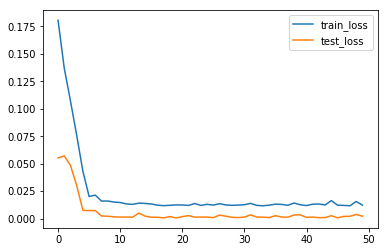

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation, Dense
# design network
model = Sequential()
model.add(LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

In the above plot we can see the errors getting close to each other and close to zero also. This shows that our model is converging well and the loss fucntion is being reduced over the time. As we can see that the model get saturated in terms of reducing the cost after 10 epochs. So training it for more epochs is not useful to as now. We can stop before that but just to see how we are performing over longer run we are running it for 50 epochs. 

Now let's see how model performs on testing dataset. We are using mean square error to test the model predictions on test data. We should have nice small floating number to give us idea that how our model has performed. 

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse =sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 45.785


In [14]:
predict_data=np.array([[10725.60,10393.90,10878.50,10246.10,6966180000,175536000000,0.059455],
                      [10366.70,9669.43,10475.00,9501.73,7287690000,163283000000,0.059455],
                      [9664.73,9796.42,9923.22,9407.06,5706940000,165407000000,0.059455],
                      [9813.07,10287.70,10597.20,9546.97,6917930000,173682000000,0.059455],
                      [10301.10,9937.07,10487.30,9734.56,7739500000,167746000000,0.059455],
                      [10005.00,10660.40,11039.10,9939.09,8040080000,179936000000,0.059455]])
#print(predict_data.shape)
c=scaler.fit_transform(predict_data)
pre=model.predict(c.reshape(predict_data.shape[0],1,predict_data.shape[1]))
phat=np.concatenate((pre,c[:,1:]),axis=1)
#print(phat)
predicted=scaler.inverse_transform(phat)
#print(predicted)

In [15]:
real_close=[10397.90,10725.60,10366.70,9664.73,9813.07,10301.10]
predicted_close=[]
date=[]
difference=[]
pr_change=[]
date=pd.date_range('2-23-2018','2-28-2018',freq='D').sort_values(ascending=False)
#print(date)
for i in range(predicted.shape[0]):
    predicted_close.append(predicted[i,0])
    difference.append(abs(predicted[i,0]-real_close[i]))
    pr_change.append((abs(predicted[i,0]-real_close[i])/predicted[i,0])*100)
#print(date)
df2=pd.DataFrame({'Date':date})
#print(len(df2))
df2['Real_close']=real_close
df2['Predicted_close']=predicted_close
#df2['Difference']=difference
#df2['Percentage_change']=pr_change
print(df2)

        Date  Real_close  Predicted_close
0 2018-02-28    10397.90     10575.508335
1 2018-02-27    10725.60      9968.105953
2 2018-02-26    10366.70      9713.071282
3 2018-02-25     9664.73     10096.263305
4 2018-02-24     9813.07     10128.082514
5 2018-02-23    10301.10     10457.213716


The above predictions are made by our LSTM model which is trained on numeric as well as sentiment score. If we see its performance then it is good. Not much improved but not bad also. We can imrpove upon it by using ensembling methods. But for that we should have large data which is quite not possible as Bitcoins are just for 7 years in market. Also geting tweets from twitter API is not free if you want to have data for long time like years or so. So we have this nice simple LSTM model which can predict the prices of Bitcoin close to the original one. 

In [16]:
combined=df.merge(df2,on='Date',how='inner')
combined.rename(columns={'real_close':'Real Close','predicted_close':'Model_numeric_data',
                        'Predicted_close':'Model_numeric _data+Sentiments'},inplace=True)
combined.drop(['Real_close','Difference','Percentage_change'],inplace=True,axis=1)
print(combined)

        Date  Real Close  Model_numeric_data  Model_numeric _data+Sentiments
0 2018-02-28    10397.90        10491.695183                    10575.508335
1 2018-02-27    10725.60         9997.942656                     9968.105953
2 2018-02-26    10366.70         9703.386253                     9713.071282
3 2018-02-25     9664.73        10050.264651                    10096.263305
4 2018-02-24     9813.07        10110.501936                    10128.082514
5 2018-02-23    10301.10        10349.661903                    10457.213716


In the above comparision we can see the real close prices, predicted prices only with numeric data and predicted prices with sentiment socre and numeric data. The prices are not much different. They are almost the same as expected. 